In [27]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import seaborn as sns
from src.experiments.common import Experiment
import torch
from hydra.utils import instantiate
import matplotlib.pyplot as plt
from src.visualization.simulated import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
def eval_poly(x, coeffs):
    return coeffs[0] + sum(c*x**i for i, c in enumerate(coeffs[1:], start=1))
run = Experiment("simulated").latest_run()
dataset = instantiate(run.runs[0].config.data.dataset)
X, Y = dataset[:]
xx = torch.linspace(-3, 3)
plt.plot(xx, eval_poly(xx, dataset.coeffs))
plt.scatter(X[:, 1], Y[:, 0]) 

In [28]:
posterior = get_exact_posterior(X, Y)
sample_data = pd.concat(
    load_samples(r)
    for r in run.runs if "sampler" in r.config["inference"]
)

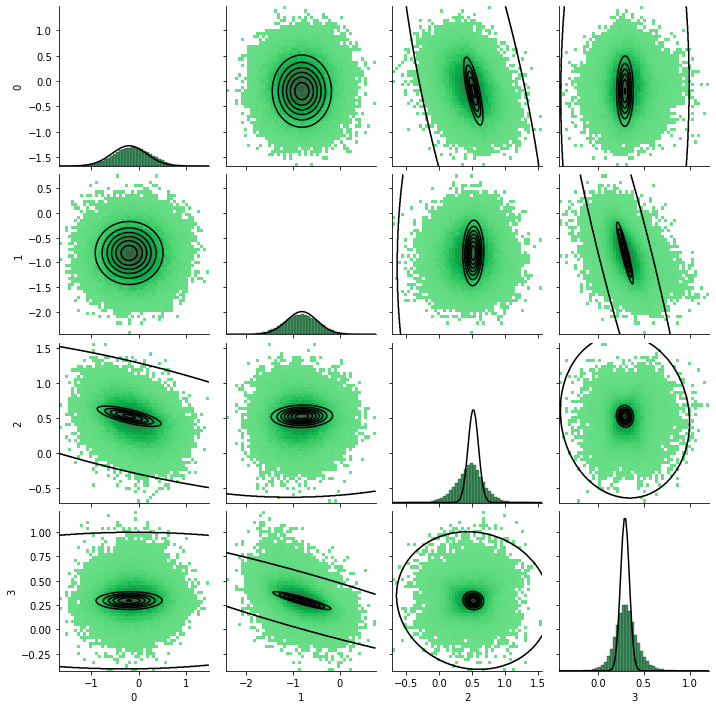

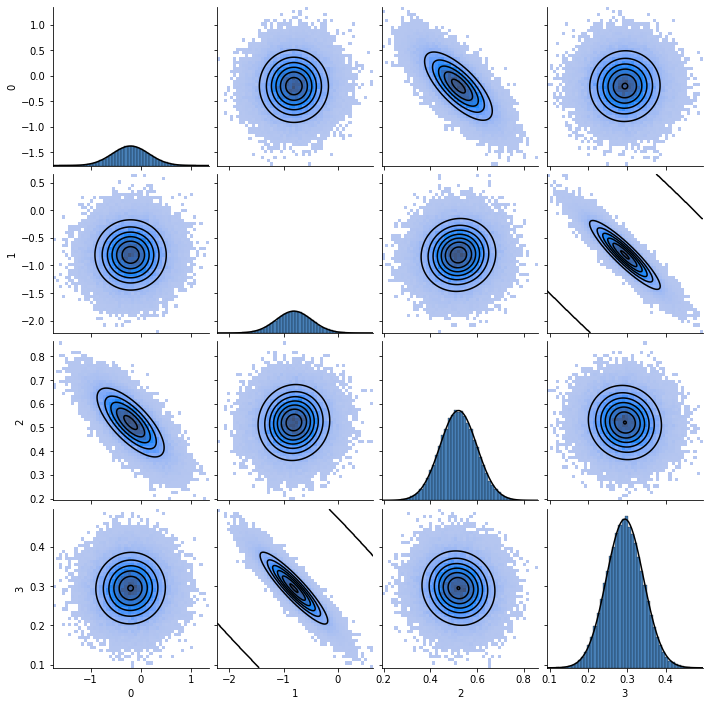

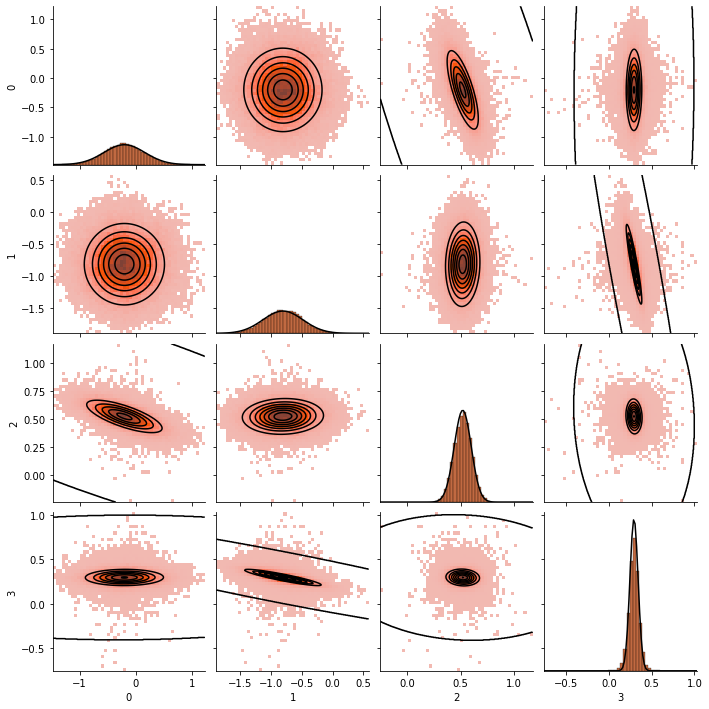

In [29]:
for key, data in sample_data.groupby(level=[0, 1]):
    with sns.color_palette(PLOT_COLORS[key]["color_palette"]):
        fg = plot_sampled_distributions_pairs(data, exact_posterior=posterior)
        plt.savefig(f"../thesis/Figures/simulated_pairs_{'_'.join(map(str, key))}.pdf")

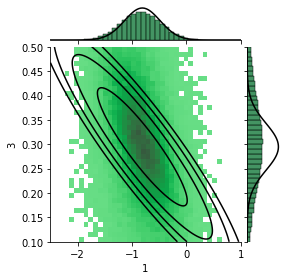

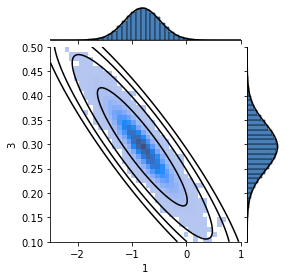

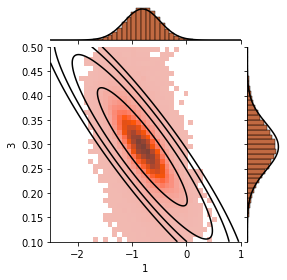

In [32]:
i = 1
j = 3
joint_plots = {}

xlims = (-2.5, 1.0)
ylims = (0.1, 0.5)

for key, data in sample_data[[i, j]].groupby(level=[0, 1]):
    with (sns.color_palette(PLOT_COLORS[key]["color_palette"])):
        joint_plots[key] = plot_sampled_joint_bivariate(
            data, exact_posterior=posterior, xlims=xlims, ylims=ylims
        )
        plt.savefig(f"../thesis/Figures/simulated_joint_{'_'.join(map(str, key))}.pdf")


In [25]:
def load_var_params(file_name):
    state_dict = torch.load(file_name)["state_dict"]
    mu = state_dict["model.linear.variational_parameters.weight.mu"].flatten().numpy()
    rho = state_dict["model.linear.variational_parameters.weight.rho"]
    sigma = rho.exp().log1p().flatten().numpy()
    return pd.DataFrame({"mu": mu, "sigma": sigma}).rename_axis("parameter")


variational_models = pd.concat(
    {
        r.config["data"]["batch_size"]: load_var_params(
            next(iter((r.path / "checkpoints").iterdir()))
        )
        for r in run.runs
        if "vi" in r.config["inference"]["_target_"]
    },
    names=["batch_size"],
)


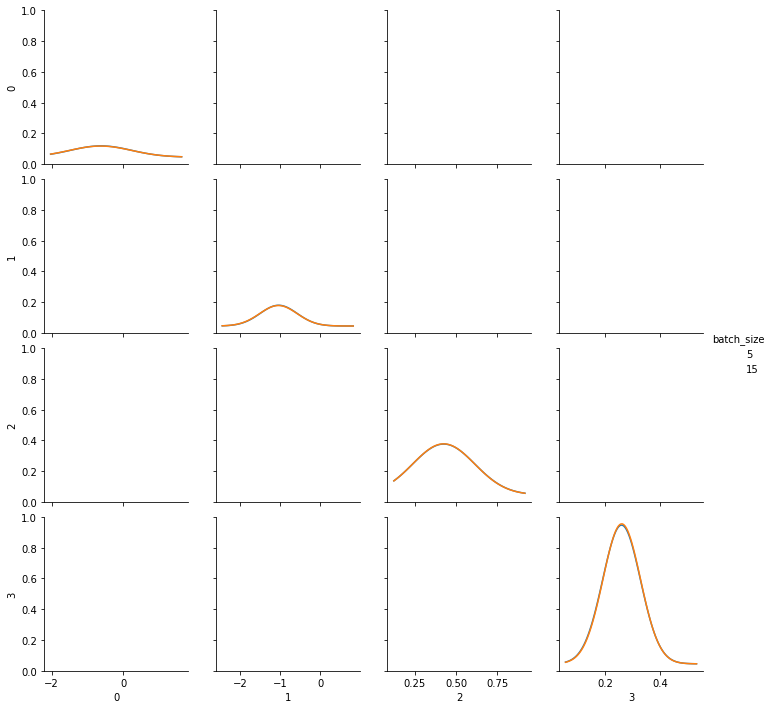

In [26]:
from torch.distributions import Normal


def draw_uni_variational(x, color, style=None, **kwargs):

    i = x.name
    marg = get_marginal(posterior, i)
    xlims = marg.mean + torch.tensor([-5, 5]) * marg.stddev
    xx = torch.linspace(*xlims)
    dist = Normal(*x.droplevel(1)[["mu", "sigma"]])
    yy = dist.log_prob(xx).exp()

    sns.lineplot(x=xx, y=yy, color=color)


def draw_bi_variational(x, **kwargs):

    i = x.name
    marg = get_marginal(posterior, i)
    xlims = marg.mean + torch.tensor([-5, 5]) * marg.stddev
    xx = torch.linspace(*xlims)
    yy = marg.log_prob(xx).exp()
    sns.lineplot(x=xx, y=yy, legend=False)

plot_data = (variational_models.rename_axis("var_param", axis=1)
    .unstack("batch_size")
    .transpose()
    .reset_index()
    .set_index("var_param", append=True)
    .reorder_levels([1, 0])
    )

pg = sns.PairGrid(plot_data, vars=[0, 1, 2, 3], hue="batch_size")

pg.map_diag(draw_uni_variational)
pg.add_legend()


In [40]:
predidictions = pd.DataFrame(
    (X @ torch.tensor(sample_data.values).view(-1, 4, 1)).squeeze().numpy()
).set_index(sample_data.index)


In [85]:

def ci_low(x):
    return x.quantile(0.05)
def ci_high(x):
    return x.quantile(0.95)
def median(x):
    return x.quantile(0.5)

predidictions = (
    pd.DataFrame(
        (X @ torch.tensor(sample_data.values).view(-1, 4, 1)).squeeze().numpy()
    )
    .set_index(sample_data.index)
    # .melt(ignore_index=False)
    .groupby(level=["sampler", "batch_size"])
    .agg(["mean", "std", ci_low, "median", ci_high])
)


In [88]:
posterior

MultivariateNormal(loc: torch.Size([4]), covariance_matrix: torch.Size([4, 4]), precision_matrix: torch.Size([4, 4]))

In [92]:
predidictions

0                                 \
                                           mean       std    ci_low    median   
sampler                    batch_size                                           
HMC                        5          -1.818150  3.630919 -7.916201 -1.605985   
                           15         -1.140139  0.812383 -2.481025 -1.138915   
SGHMC                      5          -1.100714  1.558652 -3.284126 -1.100728   
SGHMCWithVarianceEstimator 5          -1.349021  0.903975 -2.786513 -1.373193   

                                                       1                       \
                                        ci_high      mean       std    ci_low   
sampler                    batch_size                                           
HMC                        5           3.907138 -0.041642  2.231316 -3.774996   
                           15          0.199322  0.363123  0.496048 -0.451916   
SGHMC                      5           1.071588  0.382535  0.954717 -0.949761   
SGHMCWithVarianceEstimator 5           0.179212  0.275527  0.519412 -0.573686   

                                                           ...        13  \
                                         median   ci_high  ...      mean   
sampler                    batch_size                      ...             
HMC                        5           0.053767  3.513356  ...  7.197687   
                           15          0.365304  1.181785  ...  7.244159   
SGHMC                      5           0.376380  1.725207  ...  7.251051   
SGHMCWithVarianceEstimator 5           0.271960  1.136811  ...  7.186182   

                                                                     \
                                            std    ci_low    median   
sampler                    batch_size                                 
HMC                        5           2.834491  2.638140  7.110739   
                           15          0.543553  6.352185  7.243954   
SGHMC                      5           1.114445  5.704491  7.253088   
SGHMCWithVarianceEstimator 5           0.578191  6.239165  7.179631   

                                                         14            \
                                         ci_high       mean       std   
sampler                    batch_size                                   
HMC                        5           12.092566  10.730207  4.043520   
                           15           8.139041  10.744632  0.792446   
SGHMC                      5            8.818770  10.750851  1.610066   
SGHMCWithVarianceEstimator 5            8.146850  10.695464  0.879008   

                                                                       
                                         ci_low     median    ci_high  
sampler                    batch_size                                  
HMC                        5           4.284758  10.606779  17.727880  
                           15          9.444561  10.746271  12.049811  
SGHMC                      5           8.522295  10.750925  13.015109  
SGHMCWithVarianceEstimator 5           9.261281  10.681965  12.164125  

[4 rows x 75 columns]

In [ ]:
# from torch.distributions import Normal


# def draw_uni_variational(x, **kwargs):

#     i = x.name
#     marg = get_marginal(posterior, i)
#     xlims = marg.mean + torch.tensor([-5, 5]) * marg.stddev
#     xx = torch.linspace(*xlims)
#     yy = marg.log_prob(xx).exp()

#     batch_sizes = (
#         x.index.get_level_values(level="batch_size")
#         .unique()
#         .sort_values(ascending=False)
#     )
#     def get_densities(data):
#         print(data)

#     x.groupby(level="batch_sizes")

#     sns.lineplot(x=xx, y=yy, color="black")

#     mu = torch.tensor(x["mu"].values).view(2, 1)
#     sigma = torch.tensor(x["sigma"].values).view(2, 1)
#     var_dist = Normal(mu, sigma)

#     pd.DataFrame().assign(
#         batch_size=x.get,
#     )

#     d = x.copy()


# def draw_bi_variational(x, **kwargs):

#     i = x.name
#     marg = get_marginal(posterior, i)
#     xlims = marg.mean + torch.tensor([-5, 5]) * marg.stddev
#     xx = torch.linspace(*xlims)
#     yy = marg.log_prob(xx).exp()
#     sns.lineplot(x=xx, y=yy)


# pg: sns.PairGrid = (
#     variational_models.rename_axis("var_param", axis=1)
#     .unstack("batch_size")
#     .transpose()
#     .pipe((sns.PairGrid, "data"), vars=[0, 1, 2, 3])
# )
# pg.map_diag(draw_uni_variational, size="batch_size")


TypeError: unhashable type: 'Int64Index'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 5231, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'Int64Index'


TypeError: unhashable type: 'Int64Index'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 5231, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'Int64Index'


TypeError: unhashable type: 'slice'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 5231, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'slice'


TypeError: unhashable type: 'slice'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 5231, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'slice'


In [18]:

import pandas as pd
import seaborn as sns

for r in run.runs:
    model = instantiate(r.config["model"])
    


# n_samples = 10_000
# param_samples = posterior.sample((n_samples,))
# XX = torch.stack([torch.ones_like(xx), xx, xx**2, xx**3]).T
# predictions = XX @ param_samples.unsqueeze(-1)
# (
#     pd.DataFrame(predictions.squeeze().numpy(), columns=XX[:, 1].numpy())
#     .melt(
#         var_name="x",
#         value_name="y",
#     )
#     .groupby("x")
#     ç
#     .unstack()
#     .droplevel(0, axis="columns")
#     .reset_index()
#     .melt(
#         id_vars="x",
#         var_name="quantile",
#     )
#     .pipe((sns.relplot, "data"), x="x", y="value", hue="quantile", kind="line")
# )
# plt.scatter(X[:,1], y)
# plt.plot(xx, eval_poly(xx, coeffs))
# plt.plot(xx, eval_poly(xx, sgd_inf.model.linear.weight.detach()))